# Todo 
1. Load the dataset for 1 date, explore the different metrics (strike distribution, number of calls vs puts, expiry available, forward curve, etc)
2. For a given several maturities 𝑇_1,𝑇_2,𝑒𝑡𝑐, plot the implied volatility with respect to strike 𝐾, moneyness 𝑚, delta Δ for both calls and puts.
3. For a chosen maturity 𝑇_1, and using the associated 𝑆_𝑡,𝐹_𝑡,𝜎_(𝑚𝑘𝑡,𝑖) calibrate a SABR model. More precisely use Hagan’s formula (2002) and minimize the $SSE=\sum_{option\ i}\left(\sigma_{mkt,i}-\sigma_{SABR,i}\right)$ or MSE using scipy.minimize. You can use a L-BFGS-B solver.
     - Generalize to all the other smiles of this single day.
     - Using the tools provided compute the Black & Scholes (1973) greeks and prices, compare with initial values.
4. Repeat 3. but for an SSVI model Gatheral & Jacquier (2014) to get all the surface at once.
5. Generalize 3 or 4 to multiple days, compute the realized volatility for different windows.
6. Using the rule-based selection function explore the implied volatility structure through time and strikes, vs realized, skew etc.


In [ ]:
% pip install -r requirement.txt
% pip install -e .

In [6]:
# Setup auto reload
%load_ext autoreload
%autoreload 2

In [ ]:
import logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s")

from warnings import filterwarnings

filterwarnings("ignore")

import pandas as pd
import numpy as np

from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font", **{"size": 22})

from investment_lab.option_selection import select_options
from investment_lab.metrics.volatility import rolling_realized_volatility
from investment_lab.metrics.util import levels_to_returns
from investment_lab.data.option_db import OptionLoader, SPYOptionLoader, extract_spot_from_options
from investment_lab.data.rates_db import USRatesLoader
from investment_lab.pricing.black_scholes import black_scholes_price, black_scholes_greeks
from investment_lab.pricing.implied_volatility import implied_volatility_vectorized
from investment_lab.rates import compute_forward
from investment_lab.metrics.distance import mse, sse


In [12]:
df_options = OptionLoader.load_data(datetime(2022, 1, 4), datetime(2022, 1, 4), process_kwargs={"ticker":"AAPL"},)
df_options.head()

2026-01-23 09:10:36,942 | INFO | Reading between 2022-01-04 00:00:00 2022-01-04 00:00:00 from ..//data/optiondb_2016_2023.parquet


,spot,strike,expiration,delta,gamma,vega,theta,rho,implied_volatility,bid,ask,volume,call_put,option_id,mid,ticker,date,day_to_expiration,moneyness
137425,179.72,105.0,2022-01-07,0.99760,0.00019,0.00119,-0.02392,0.01073,1.96065,74.65,74.85,1.0,C,AAPL 20220107C105,74.750,AAPL,2022-01-04,3,0.584242
137426,179.72,110.0,2022-01-07,0.99732,0.00022,0.00186,-0.02303,0.01071,1.80137,69.65,69.85,0.0,C,AAPL 20220107C110,69.750,AAPL,2022-01-04,3,0.612063
137427,179.72,115.0,2022-01-07,0.99724,0.00028,0.00164,-0.02307,0.01166,1.65001,64.65,64.85,0.0,C,AAPL 20220107C115,64.750,AAPL,2022-01-04,3,0.639884
137428,179.72,120.0,2022-01-07,0.99471,0.00054,0.00250,-0.04105,0.01216,1.61633,59.60,59.95,10.0,C,AAPL 20220107C120,59.775,AAPL,2022-01-04,3,0.667705
137429,179.72,125.0,2022-01-07,0.99422,0.00060,0.00349,-0.04125,0.01248,1.46774,54.60,54.95,0.0,C,AAPL 20220107C125,54.775,AAPL,2022-01-04,3,0.695526


In [9]:
df_spot = extract_spot_from_options(df_options)
df_spot.head()

,date,spot
0,2022-01-04,477.56


In [10]:
df_rates = USRatesLoader.load_data(datetime(2022, 1, 4), datetime(2022, 1, 4))
df_rates.head()

2026-01-23 09:10:23,718 | INFO | Reading between 2022-01-04 00:00:00 2022-01-04 00:00:00 from ..//data/par-yield-curve-rates-2020-2023.csv


,date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
503,2022-01-04,0.0006,0.0005,0.0008,NaN,0.0022,0.0038,0.0077,0.0102,0.0137,0.0157,0.0166,0.021,0.0207


In [21]:
df_options = compute_forward(df_options=df_options, df_rates=df_rates)
df_options.head()

,spot,strike,expiration,delta,gamma,vega,theta,rho,implied_volatility,bid,...,volume,call_put,option_id,mid,ticker,date,day_to_expiration,moneyness,risk_free_rate,forward
0,179.72,105.0,2022-01-07,0.99760,0.00019,0.00119,-0.02392,0.01073,1.96065,74.65,...,1.0,C,AAPL 20220107C105,74.750,AAPL,2022-01-04,3,0.584242,0.0006,179.720886
1,179.72,110.0,2022-01-07,0.99732,0.00022,0.00186,-0.02303,0.01071,1.80137,69.65,...,0.0,C,AAPL 20220107C110,69.750,AAPL,2022-01-04,3,0.612063,0.0006,179.720886
2,179.72,115.0,2022-01-07,0.99724,0.00028,0.00164,-0.02307,0.01166,1.65001,64.65,...,0.0,C,AAPL 20220107C115,64.750,AAPL,2022-01-04,3,0.639884,0.0006,179.720886
3,179.72,120.0,2022-01-07,0.99471,0.00054,0.00250,-0.04105,0.01216,1.61633,59.60,...,10.0,C,AAPL 20220107C120,59.775,AAPL,2022-01-04,3,0.667705,0.0006,179.720886
4,179.72,125.0,2022-01-07,0.99422,0.00060,0.00349,-0.04125,0.01248,1.46774,54.60,...,0.0,C,AAPL 20220107C125,54.775,AAPL,2022-01-04,3,0.695526,0.0006,179.720886


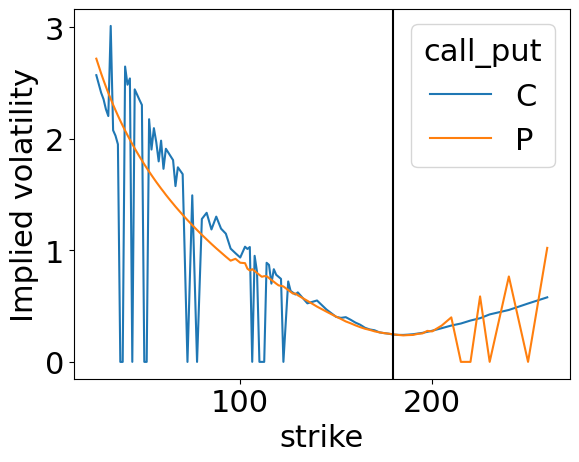

In [34]:
df_single_expiry = df_options.loc[df_options.expiration=="2022-01-21"]
ax = df_single_expiry.pivot_table(index="strike",columns="call_put",values='implied_volatility').sort_index().plot()
ax.set_xlabel("strike")
ax.set_ylabel("Implied volatility")
ax.axvline(x=df_single_expiry['spot'].iloc[0],label="spot",color="black")

Text(0, 0.5, 'Implied volatility')

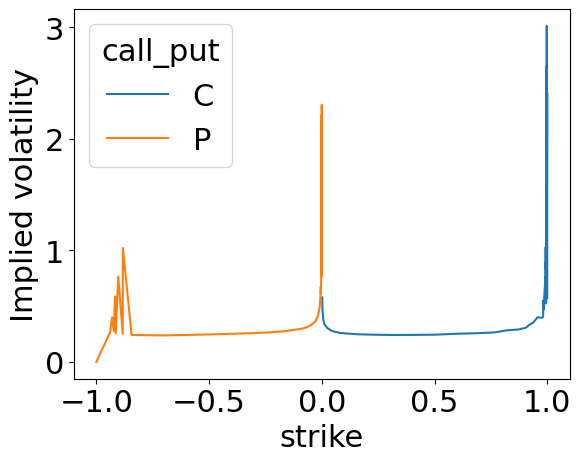

In [37]:
df_single_expiry = df_options.loc[df_options.expiration=="2022-01-21"]
ax = df_single_expiry.pivot_table(index="delta",columns="call_put",values='implied_volatility').sort_index().plot()
ax.set_xlabel("strike")
ax.set_ylabel("Implied volatility")
# ax.axvline(x=df_single_expiry['spot'].iloc[0],label="spot",color="black")

In [54]:

def hagan_vol(
    params: tuple[float, float, float, float], forward: pd.Series | np.ndarray, strike: pd.Series | np.ndarray, time_to_maturities: pd.Series | np.ndarray
) -> pd.Series | np.ndarray:
    """
    Compute implied volatility using SABR model.

    Parameters:
        params: tuple of (alpha, beta, rho, nu)
        forward: forward price
        strike: strike price
        time_to_maturities: time to maturity (in years)
        

    Returns:
        SABR implied volatility
    """
    alpha, beta, rho, nu = params
    forward = np.asarray(forward)
    time_to_maturities = np.asarray(time_to_maturities)

    z = (nu / alpha) * (forward * strike) ** ((1 - beta) / 2) * np.log(forward / strike)
    chi = np.log((np.sqrt(1 - 2 * rho * z + z**2) + z - rho) / (1 - rho))

    num = alpha
    denom = (forward * strike) ** ((1 - beta) / 2) * (
        1 + ((1 - beta) ** 2 / 24) * (np.log(forward / strike)) ** 2 + ((1 - beta) ** 4 / 1920) * (np.log(forward / strike)) ** 4
    )

    vol = (num / denom) * (z / chi)
    sabr_implied_vol = vol * np.sqrt(
        1
        + ((1 - beta) ** 2 / 24) * (alpha / ((forward * strike) ** ((1 - beta) / 2))) ** 2 * time_to_maturities
        + (rho * beta * nu * alpha / ((forward * strike) ** ((1 - beta) / 2))) * time_to_maturities
        + ((2 - 3 * rho**2) / 24) * (nu**2) * time_to_maturities
    )
    return np.where(forward == strike, alpha / (forward ** (1 - beta)), sabr_implied_vol)


In [58]:
from scipy.optimize import minimize

def fit(
    forward: float | pd.Series | np.ndarray,
    strike: pd.Series | np.ndarray,
    time_to_maturities: pd.Series | np.ndarray | float,
    market_implied_vols: pd.Series | np.ndarray,
    initial_guess: tuple[float, float, float, float]
):
    """
    Calibrate SABR parameters to market implied volatilities.

    Parameters:
        forward: forward price
        strike: array of strikes
        time_to_maturities: time to maturity
        market_implied_vols: array of market implied volatilities

    Returns:
    Calibrated parameters (alpha, beta, rho, nu)
    """

    def _objective_func(params: tuple[float, float, float, float]) -> float:
        model_vol = hagan_vol(params, forward=forward, strike=strike, time_to_maturities=time_to_maturities)
        return mse(market_implied_vols, model_vol)

    bounds = [(1e-6, None), (0, 2), (-0.999, 0.999), (1e-6, None)]
    result = minimize(_objective_func,
                      initial_guess,
                      method="L-BFGS-B", bounds=bounds,
                      options={"maxiter": 1000, "disp": True})
    return result.x




In [ ]:
put_strike_filter = (df_single_expiry["call_put"]=='P') & (df_single_expiry["strike"]<=df_single_expiry["forward"]) 
call_strike_filter = (df_single_expiry["call_put"]=='C') & (df_single_expiry["strike"]>=df_single_expiry["forward"]) 

df_single_expiry_filtered = df_single_expiry.loc[put_strike_filter | call_strike_filter ]

params = fit( 
    df_single_expiry_filtered['forward'],
    df_single_expiry_filtered['strike'],
    df_single_expiry_filtered['day_to_expiration']/252,
    df_single_expiry_filtered['implied_volatility'],
    initial_guess=(0.2, 0.75, -0.5, 0.2)
)
params

array([0.76477446, 0.57856067, 0.00747775, 6.34505204])

In [62]:
df_single_expiry['implied_volatility_SABR'] =  hagan_vol(params, df_single_expiry['forward'],
                                                        df_single_expiry['strike'],
                                                        df_single_expiry['day_to_expiration']/252)
df_single_expiry[['implied_volatility_SABR',"implied_volatility"]]

,implied_volatility_SABR,implied_volatility
196,2.556986,2.56974
197,2.453690,2.41264
198,2.405184,2.35488
199,2.358546,2.26471
200,2.313630,2.20327
...,...,...
395,0.445191,0.58675
396,0.475586,0.00000
397,0.532988,0.76557
398,0.586484,0.00000


<Axes: xlabel='implied_volatility', ylabel='implied_volatility_SABR'>

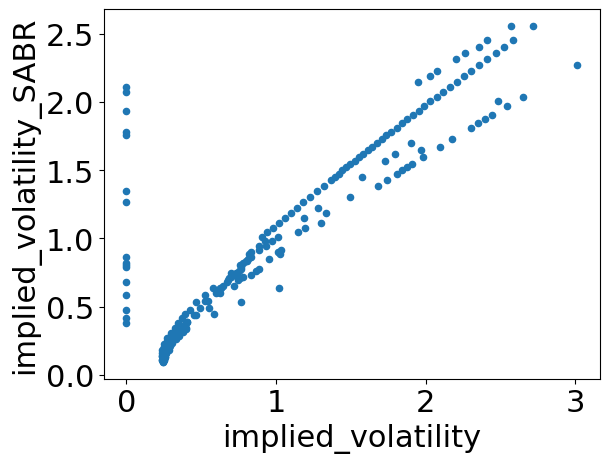

In [65]:
df_single_expiry[['implied_volatility_SABR',"implied_volatility"]].plot.scatter(x="implied_volatility",
                                                                                y="implied_volatility_SABR")

Text(0, 0.5, 'Implied volatility')

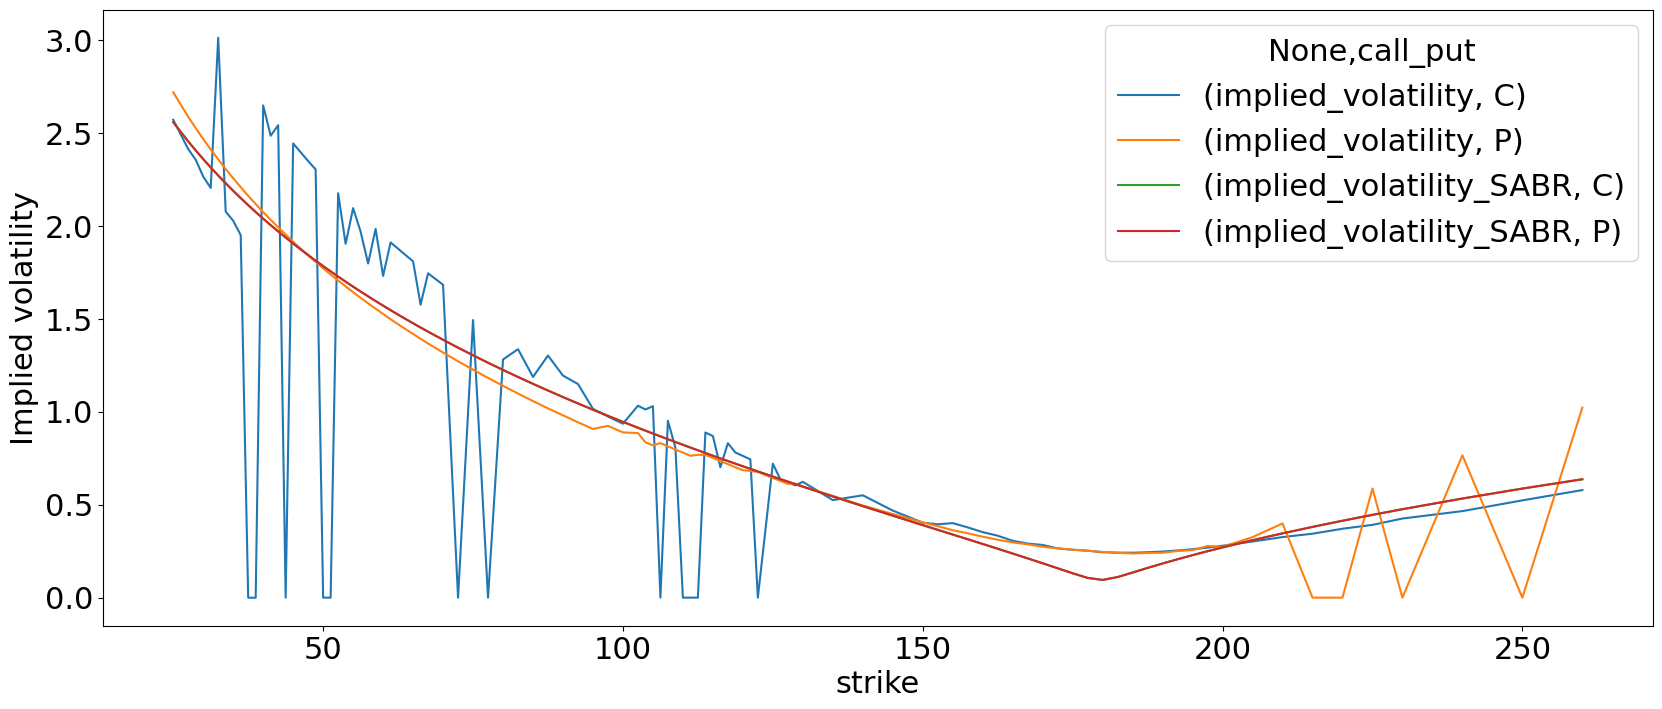

In [67]:
ax = df_single_expiry.pivot_table(index="strike",columns="call_put",
                                  values=['implied_volatility_SABR',"implied_volatility"]).sort_index().plot(figsize=(20,8))
ax.set_xlabel("strike")
ax.set_ylabel("Implied volatility")

In [84]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

def fit_ssvi(
    forward: float | pd.Series | np.ndarray,
    strike: pd.Series | np.ndarray,
    time_to_maturities: pd.Series | np.ndarray,
    market_implied_vols: pd.Series | np.ndarray,
    initial_guess: tuple[float, float, float, float]  # (rho, eta, lambda)
):
    """
    Calibrate SSVI parameters (rho, eta, lambda) to market implied volatilities.
    Note: theta (ATM variance) is usually pre-calculated from market ATM vols.
    """
    def objective(params: tuple[float, float, float, float]) -> float:
        model_total_variance = ssvi_total_variance(params, forward=forward, strike=strike, time_to_maturities=time_to_maturities)
        # Calculate Mean Squared Error
        market_implied_variance = (market_implied_vols**2)*(time_to_maturities)
        return float(np.mean((market_implied_variance - model_total_variance)**2))

    # Constraints for arbitrage-free SSVI:
    # |rho| < 1
    # eta > 0
    # lambda <= 0.5 (Necessary condition for no-butterfly arbitrage)
    bounds = [(0.00001,None), (-0.999, 0.999), (1e-6, 5.0), (1e-6, 0.5)]
    
    result = minimize(
        objective, 
        initial_guess, 
        method="L-BFGS-B", 
        bounds=bounds, 
        options={"maxiter": 1000, "disp": False}
    )
    return result.x


def ssvi_implied_vol(
    params: tuple[float, float, float, float], 
    forward: pd.Series | np.ndarray,
    strike: pd.Series | np.ndarray,
    time_to_maturities: pd.Series | np.ndarray,
) -> np.ndarray:
    """
    Compute Total Variance w(k, theta) using SSVI with Power Law kernel.

    Parameters:
        params: tuple of (sigma, rho, eta, lamb)
        
    Returns:
        SSVI total variance
    """
    # Convert model total variance back to implied vol: sigma = sqrt(w / T)
    total_variance = ssvi_total_variance(params,
                                         forward=forward,
                                         strike=strike,
                                         time_to_maturities=time_to_maturities)
    return np.sqrt(total_variance / np.asarray(time_to_maturities))
     

def ssvi_total_variance(
    params: tuple[float, float, float, float], 
    forward: pd.Series | np.ndarray,
    strike: pd.Series | np.ndarray,
    time_to_maturities: pd.Series | np.ndarray,
) -> np.ndarray:
    """
    Compute Total Variance w(k, theta) using SSVI with Power Law kernel.

    Parameters:
        params: tuple of (sigma, rho, eta, lamb)
        
    Returns:
        SSVI total variance
    """
    # 1. Pre-calculate log-moneyness (k) and ATM Total Variance (theta) theta: ATM total variance (sigma_atm^2 * T)

    k = np.log(np.asarray(strike) / np.asarray(forward))
    sigma, rho, eta, lamb = params
    theta = sigma*sigma*time_to_maturities
    
    # Power Law kernel: phi(theta)
    phi = eta / (theta**lamb)
    
    # SSVI Formula
    # w(k, theta) = 0.5 * theta * (1 + rho*phi*k + sqrt((phi*k + rho)^2 + 1 - rho^2))
    inner_sqrt = np.sqrt((phi * k + rho)**2 + 1 - rho**2)
    return 0.5 * theta * (1 + rho * phi * k + inner_sqrt)
    
     

In [85]:
put_strike_filter = (df_options["call_put"]=='P') & (df_options["strike"]<=df_options["forward"]) 
call_strike_filter = (df_options["call_put"]=='C') & (df_options["strike"]>=df_options["forward"]) 

df_options_filtered = df_options.loc[put_strike_filter | call_strike_filter ]

In [87]:

params = fit_ssvi(df_options_filtered['forward'],
                  df_options_filtered['strike'],
                  df_options_filtered["day_to_expiration"]/252,
                  df_options_filtered['implied_volatility'],
                  (0.2, -0.4, 0.2, 0.4)) # sigma, rho, eta, lamb

df_options['implied_volatility_SSVI'] = ssvi_implied_vol(params,
                                                        df_options['forward'],
                                                        df_options['strike'],
                                                        df_options["day_to_expiration"]/365.25)
df_options.head()

,spot,strike,expiration,delta,gamma,vega,theta,rho,implied_volatility,bid,...,call_put,option_id,mid,ticker,date,day_to_expiration,moneyness,risk_free_rate,forward,implied_volatility_SSVI
0,179.72,105.0,2022-01-07,0.99760,0.00019,0.00119,-0.02392,0.01073,1.96065,74.65,...,C,AAPL 20220107C105,74.750,AAPL,2022-01-04,3,0.584242,0.0006,179.720886,1.285046
1,179.72,110.0,2022-01-07,0.99732,0.00022,0.00186,-0.02303,0.01071,1.80137,69.65,...,C,AAPL 20220107C110,69.750,AAPL,2022-01-04,3,0.612063,0.0006,179.720886,1.229538
2,179.72,115.0,2022-01-07,0.99724,0.00028,0.00164,-0.02307,0.01166,1.65001,64.65,...,C,AAPL 20220107C115,64.750,AAPL,2022-01-04,3,0.639884,0.0006,179.720886,1.174051
3,179.72,120.0,2022-01-07,0.99471,0.00054,0.00250,-0.04105,0.01216,1.61633,59.60,...,C,AAPL 20220107C120,59.775,AAPL,2022-01-04,3,0.667705,0.0006,179.720886,1.118353
4,179.72,125.0,2022-01-07,0.99422,0.00060,0.00349,-0.04125,0.01248,1.46774,54.60,...,C,AAPL 20220107C125,54.775,AAPL,2022-01-04,3,0.695526,0.0006,179.720886,1.062194


In [91]:
df_options.expiration.unique()

<DatetimeArray>
['2022-01-07 00:00:00', '2022-01-14 00:00:00', '2022-01-21 00:00:00',
 '2022-01-28 00:00:00', '2022-02-04 00:00:00', '2022-02-11 00:00:00',
 '2022-02-18 00:00:00', '2022-03-18 00:00:00', '2022-04-14 00:00:00',
 '2022-05-20 00:00:00', '2022-06-17 00:00:00', '2022-07-15 00:00:00',
 '2022-09-16 00:00:00', '2023-01-20 00:00:00', '2023-03-17 00:00:00',
 '2023-06-16 00:00:00', '2023-09-15 00:00:00', '2024-01-19 00:00:00']
Length: 18, dtype: datetime64[ns]

Text(0, 0.5, 'Implied volatility')

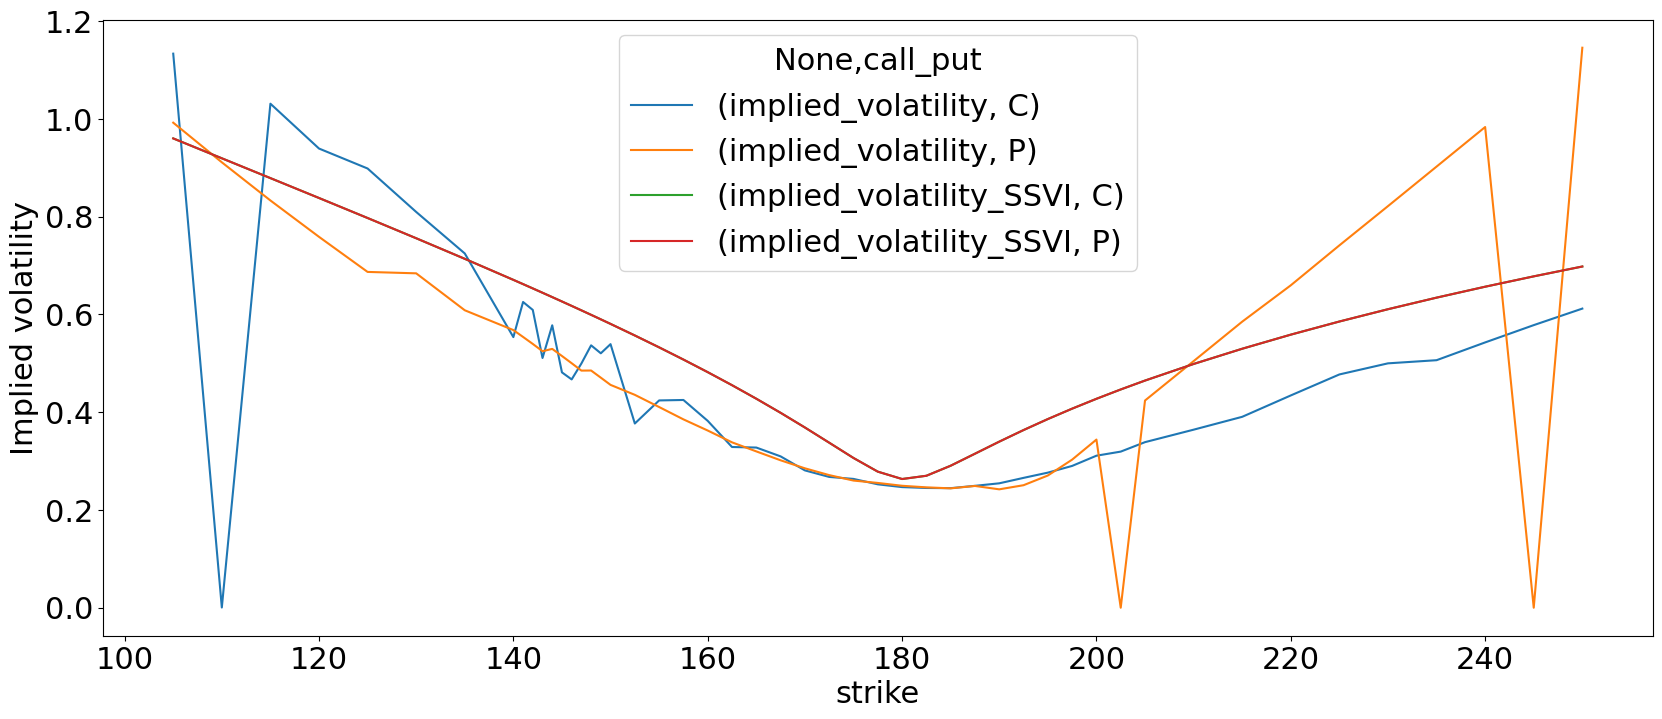

In [92]:
ax = df_options[df_options.expiration=="2022-01-14"].pivot_table(index="strike",columns="call_put",
                                  values=['implied_volatility_SSVI',
                                          "implied_volatility"]).sort_index().plot(figsize=(20,8))
ax.set_xlabel("strike")
ax.set_ylabel("Implied volatility")

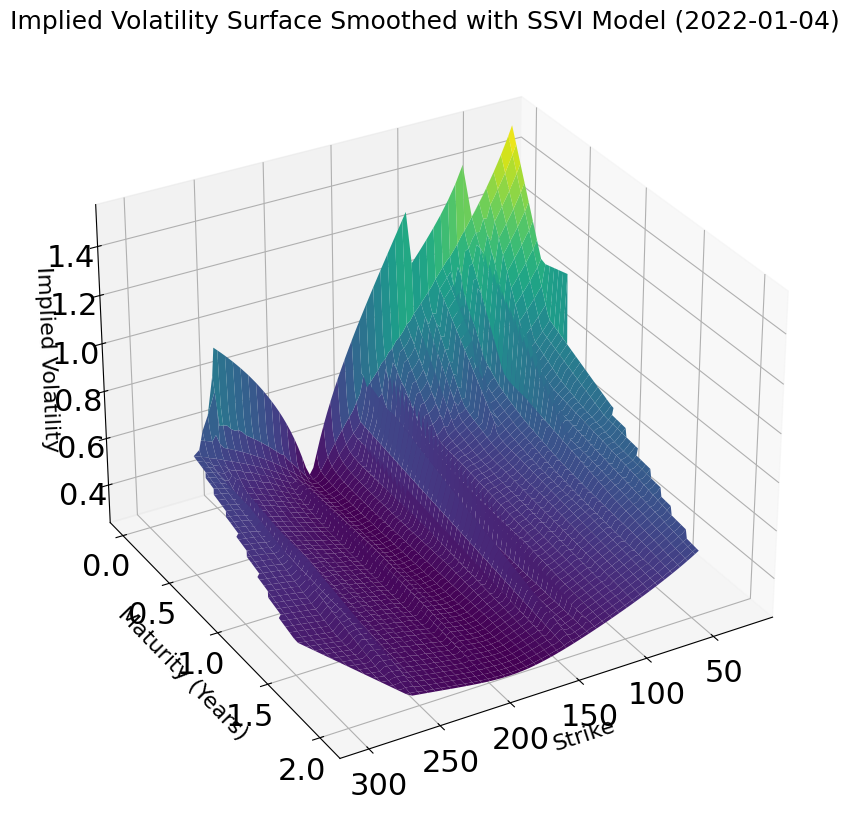

In [96]:
import scipy.interpolate as interp

df_options_copy = df_options.copy()
# df_options_copy = df_options_copy[df_options_copy["moneyness"].between(0.8, 1.2)]
# df_options_copy = df_options_copy[df_options_copy["day_to_expiration"].between(1, 365.25)]

put_strike_filter = (df_options_copy["call_put"]=='P') & (df_options_copy["strike"]<=df_options_copy["forward"]) 
call_strike_filter = (df_options_copy["call_put"]=='C') & (df_options_copy["strike"]>=df_options_copy["forward"]) 

df_options_copy = df_options_copy[put_strike_filter | call_strike_filter]

strikes = df_options_copy["strike"].values
expirations = df_options_copy["day_to_expiration"].values / 365.25
implied_volatility = df_options_copy["implied_volatility_SSVI"].values

# Create grid
strike_grid, exp_grid = np.meshgrid(np.linspace(strikes.min(), strikes.max(), 100), np.linspace(expirations.min(), expirations.max(), 100))

# Interpolate
vol_grid = interp.griddata((strikes, expirations), implied_volatility, (strike_grid, exp_grid), method="linear")

# Plot 3D surface
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(strike_grid, exp_grid, vol_grid, cmap="viridis", edgecolor="none")
ax.set_xlabel("Strike", fontsize=16)
ax.set_ylabel("Maturity (Years)", fontsize=16)
ax.set_zlabel("Implied Volatility", fontsize=16)
ax.set_title("Implied Volatility Surface Smoothed with SSVI Model (2022-01-04)", fontsize=18)
ax.view_init(elev=30, azim=60)  # Adjust azimuth and elevation as needed

# Reprice the dataset and see

In [97]:
df_options.head()

,spot,strike,expiration,delta,gamma,vega,theta,rho,implied_volatility,bid,...,call_put,option_id,mid,ticker,date,day_to_expiration,moneyness,risk_free_rate,forward,implied_volatility_SSVI
0,179.72,105.0,2022-01-07,0.99760,0.00019,0.00119,-0.02392,0.01073,1.96065,74.65,...,C,AAPL 20220107C105,74.750,AAPL,2022-01-04,3,0.584242,0.0006,179.720886,1.285046
1,179.72,110.0,2022-01-07,0.99732,0.00022,0.00186,-0.02303,0.01071,1.80137,69.65,...,C,AAPL 20220107C110,69.750,AAPL,2022-01-04,3,0.612063,0.0006,179.720886,1.229538
2,179.72,115.0,2022-01-07,0.99724,0.00028,0.00164,-0.02307,0.01166,1.65001,64.65,...,C,AAPL 20220107C115,64.750,AAPL,2022-01-04,3,0.639884,0.0006,179.720886,1.174051
3,179.72,120.0,2022-01-07,0.99471,0.00054,0.00250,-0.04105,0.01216,1.61633,59.60,...,C,AAPL 20220107C120,59.775,AAPL,2022-01-04,3,0.667705,0.0006,179.720886,1.118353
4,179.72,125.0,2022-01-07,0.99422,0.00060,0.00349,-0.04125,0.01248,1.46774,54.60,...,C,AAPL 20220107C125,54.775,AAPL,2022-01-04,3,0.695526,0.0006,179.720886,1.062194


In [103]:
df_options['mid_BS'] = black_scholes_price(
    S=df_options['spot'],
    K=df_options['strike'],
    option_type=df_options['call_put'],
    r=df_options['risk_free_rate'],
    T=df_options['day_to_expiration']/365.25,
    sigma=df_options['implied_volatility_SSVI']  
    
)
df_options[[ 'delta_BS', 'gamma_BS', 'vega_BS', 'theta_BS','rho_BS']] = black_scholes_greeks(
    S=df_options['spot'],
    K=df_options['strike'],
    option_type=df_options['call_put'],
    r=df_options['risk_free_rate'],
    T=df_options['day_to_expiration']/365.25,
    sigma=df_options['implied_volatility_SSVI']  
)
df_options.head()

,spot,strike,expiration,delta,gamma,vega,theta,rho,implied_volatility,bid,...,moneyness,risk_free_rate,forward,implied_volatility_SSVI,mid_BS,delta_BS,gamma_BS,vega_BS,theta_BS,rho_BS
0,179.72,105.0,2022-01-07,0.99760,0.00019,0.00119,-0.02392,0.01073,1.96065,74.65,...,0.584242,0.0006,179.720886,1.285046,74.720524,0.999999,3.453898e-07,0.000118,-0.072211,0.862417
1,179.72,110.0,2022-01-07,0.99732,0.00022,0.00186,-0.02303,0.01071,1.80137,69.65,...,0.612063,0.0006,179.720886,1.229538,69.720559,0.999996,9.490810e-07,0.000310,-0.089170,0.903480
2,179.72,115.0,2022-01-07,0.99724,0.00028,0.00164,-0.02307,0.01166,1.65001,64.65,...,0.639884,0.0006,179.720886,1.174051,64.720612,0.999989,2.503134e-06,0.000780,-0.124720,0.944538
3,179.72,120.0,2022-01-07,0.99471,0.00054,0.00250,-0.04105,0.01216,1.61633,59.60,...,0.667705,0.0006,179.720886,1.118353,59.720705,0.999973,6.362267e-06,0.001888,-0.200505,0.985580
4,179.72,125.0,2022-01-07,0.99422,0.00060,0.00349,-0.04125,0.01248,1.46774,54.60,...,0.695526,0.0006,179.720886,1.062194,54.720893,0.999933,1.564187e-05,0.004408,-0.360002,1.026588


<Axes: xlabel='implied_volatility', ylabel='implied_volatility_SSVI'>

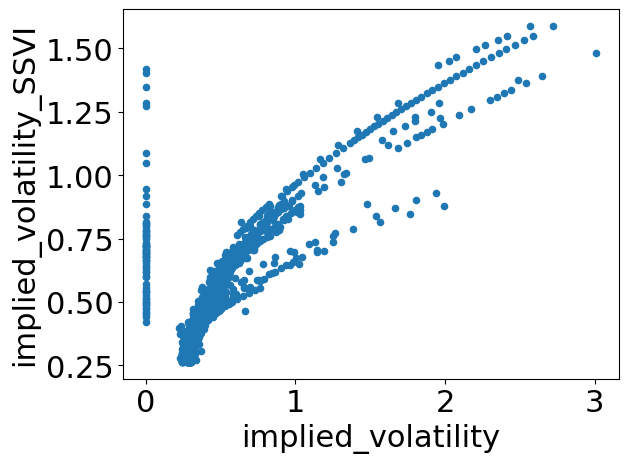

In [104]:
df_options.plot.scatter(x='implied_volatility', y='implied_volatility_SSVI')

array([[<Axes: title={'center': 'delta_BS'}>,
        <Axes: title={'center': 'delta'}>]], dtype=object)

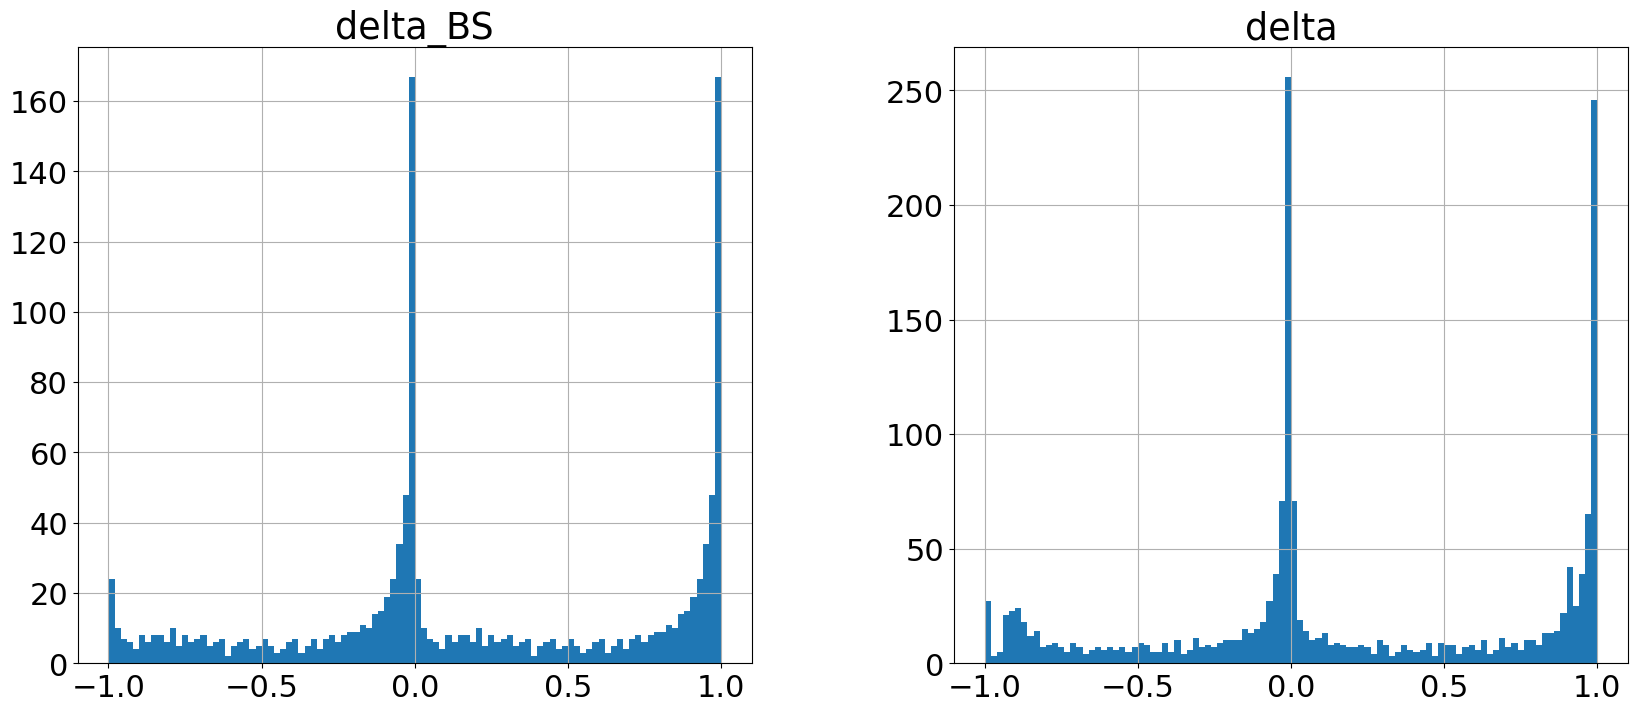

In [106]:
df_options[['delta_BS',"delta"]].hist(bins=100, figsize=(20,8))

<Axes: xlabel='mid', ylabel='mid_BS'>

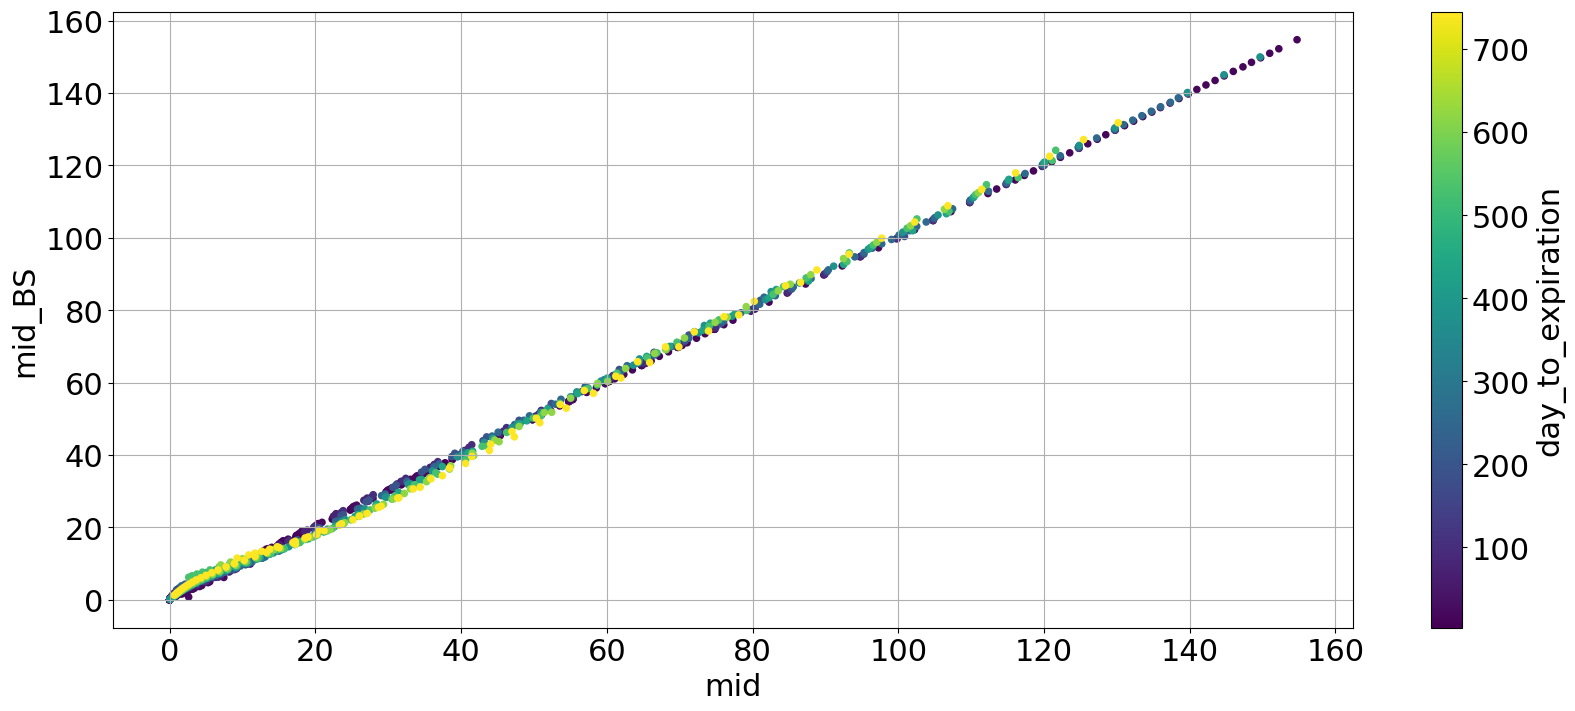

In [113]:
df_options.plot.scatter(x='mid', y='mid_BS',grid=True,figsize=(20,8),c="day_to_expiration",cmap='viridis')

# Time Series Calibration

In [114]:
df_options = OptionLoader.load_data(datetime(2020, 1, 4), datetime(2020, 12, 4), process_kwargs={"ticker":"AAPL"},)
print(df_options.shape)
df_options.head()

2026-01-23 11:15:50,536 | INFO | Reading between 2020-01-04 00:00:00 2020-12-04 00:00:00 from ..//data/optiondb_2016_2023.parquet


(545254, 19)


,spot,strike,expiration,delta,gamma,vega,theta,rho,implied_volatility,bid,ask,volume,call_put,option_id,mid,ticker,date,day_to_expiration,moneyness
169768,299.8,200.0,2020-01-10,1.00000,0.00000,0.00000,-0.00004,0.02788,0.00000,99.15,99.95,0.0,C,AAPL 20200110C200,99.550,AAPL,2020-01-06,4,0.667111
169769,299.8,205.0,2020-01-10,0.99821,0.00015,0.00173,-0.01508,0.02786,1.13225,94.56,95.05,2.0,C,AAPL 20200110C205,94.805,AAPL,2020-01-06,4,0.683789
169770,299.8,210.0,2020-01-10,0.99075,0.00057,0.00840,-0.08789,0.02864,1.32704,89.65,90.20,0.0,C,AAPL 20200110C210,89.925,AAPL,2020-01-06,4,0.700467
169771,299.8,215.0,2020-01-10,0.99618,0.00028,0.00362,-0.03106,0.02948,1.08562,84.70,84.95,5.0,C,AAPL 20200110C215,84.825,AAPL,2020-01-06,4,0.717145
169772,299.8,220.0,2020-01-10,1.00000,0.00000,0.00000,-0.00048,0.03037,0.00000,79.34,80.05,0.0,C,AAPL 20200110C220,79.695,AAPL,2020-01-06,4,0.733823


In [121]:
df_rates = USRatesLoader.load_data(datetime(2020, 1, 4), datetime(2020, 12, 4),)
df_options = compute_forward(df_options=df_options, df_rates=df_rates)
df_options.head()

2026-01-23 11:21:45,177 | INFO | Reading between 2020-01-04 00:00:00 2020-12-04 00:00:00 from ..//data/par-yield-curve-rates-2020-2023.csv


,spot,strike,expiration,delta,gamma,vega,theta,rho,implied_volatility,bid,...,volume,call_put,option_id,mid,ticker,date,day_to_expiration,moneyness,risk_free_rate,forward
0,299.8,200.0,2020-01-10,1.00000,0.00000,0.00000,-0.00004,0.02788,0.00000,99.15,...,0.0,C,AAPL 20200110C200,99.550,AAPL,2020-01-06,4,0.667111,0.0154,299.850566
1,299.8,205.0,2020-01-10,0.99821,0.00015,0.00173,-0.01508,0.02786,1.13225,94.56,...,2.0,C,AAPL 20200110C205,94.805,AAPL,2020-01-06,4,0.683789,0.0154,299.850566
2,299.8,210.0,2020-01-10,0.99075,0.00057,0.00840,-0.08789,0.02864,1.32704,89.65,...,0.0,C,AAPL 20200110C210,89.925,AAPL,2020-01-06,4,0.700467,0.0154,299.850566
3,299.8,215.0,2020-01-10,0.99618,0.00028,0.00362,-0.03106,0.02948,1.08562,84.70,...,5.0,C,AAPL 20200110C215,84.825,AAPL,2020-01-06,4,0.717145,0.0154,299.850566
4,299.8,220.0,2020-01-10,1.00000,0.00000,0.00000,-0.00048,0.03037,0.00000,79.34,...,0.0,C,AAPL 20200110C220,79.695,AAPL,2020-01-06,4,0.733823,0.0154,299.850566


In [122]:

def daily_vol_calibration(df_day_group: pd.DataFrame) -> pd.DataFrame:
    put_strike_filter = (df_day_group["call_put"]=='P') & (df_day_group["strike"]<=df_day_group["forward"]) 
    call_strike_filter = (df_day_group["call_put"]=='C') & (df_day_group["strike"]>=df_day_group["forward"]) 
    df_options_filtered = df_day_group.loc[put_strike_filter | call_strike_filter ]
    params = fit_ssvi(df_options_filtered['forward'],
                    df_options_filtered['strike'],
                    df_options_filtered["day_to_expiration"]/252,
                    df_options_filtered['implied_volatility'],
                    (0.2, -0.4, 0.2, 0.4)) # sigma, rho, eta, lamb

    df_day_group['implied_volatility_SSVI'] = ssvi_implied_vol(params,
                                                            df_day_group['forward'],
                                                            df_day_group['strike'],
                                                            df_day_group["day_to_expiration"]/365.25)
    
    return df_day_group

df_options_calibrated = df_options.groupby('date').apply(daily_vol_calibration).reset_index(drop=True)
df_options_calibrated.head()


,spot,strike,expiration,delta,gamma,vega,theta,rho,implied_volatility,bid,...,call_put,option_id,mid,ticker,date,day_to_expiration,moneyness,risk_free_rate,forward,implied_volatility_SSVI
0,299.8,200.0,2020-01-10,1.00000,0.00000,0.00000,-0.00004,0.02788,0.00000,99.15,...,C,AAPL 20200110C200,99.550,AAPL,2020-01-06,4,0.667111,0.0154,299.850566,0.863788
1,299.8,205.0,2020-01-10,0.99821,0.00015,0.00173,-0.01508,0.02786,1.13225,94.56,...,C,AAPL 20200110C205,94.805,AAPL,2020-01-06,4,0.683789,0.0154,299.850566,0.838255
2,299.8,210.0,2020-01-10,0.99075,0.00057,0.00840,-0.08789,0.02864,1.32704,89.65,...,C,AAPL 20200110C210,89.925,AAPL,2020-01-06,4,0.700467,0.0154,299.850566,0.812567
3,299.8,215.0,2020-01-10,0.99618,0.00028,0.00362,-0.03106,0.02948,1.08562,84.70,...,C,AAPL 20200110C215,84.825,AAPL,2020-01-06,4,0.717145,0.0154,299.850566,0.786678
4,299.8,220.0,2020-01-10,1.00000,0.00000,0.00000,-0.00048,0.03037,0.00000,79.34,...,C,AAPL 20200110C220,79.695,AAPL,2020-01-06,4,0.733823,0.0154,299.850566,0.760538


In [130]:
df_selected_90P = select_options(
    df_options_calibrated,
    call_or_put='P',
    strike_col="moneyness",
    strike_target=0.9,
    day_to_expiry_target=40,
)
df_selected_110C = select_options(
    df_options_calibrated,
    call_or_put='C',
    strike_col="moneyness",
    strike_target=1.1,
    day_to_expiry_target=40,
)
df_selected_100C = select_options(
    df_options_calibrated,
    call_or_put='C',
    strike_col="moneyness",
    strike_target=1.0,
    day_to_expiry_target=40,
)


<Axes: xlabel='date'>

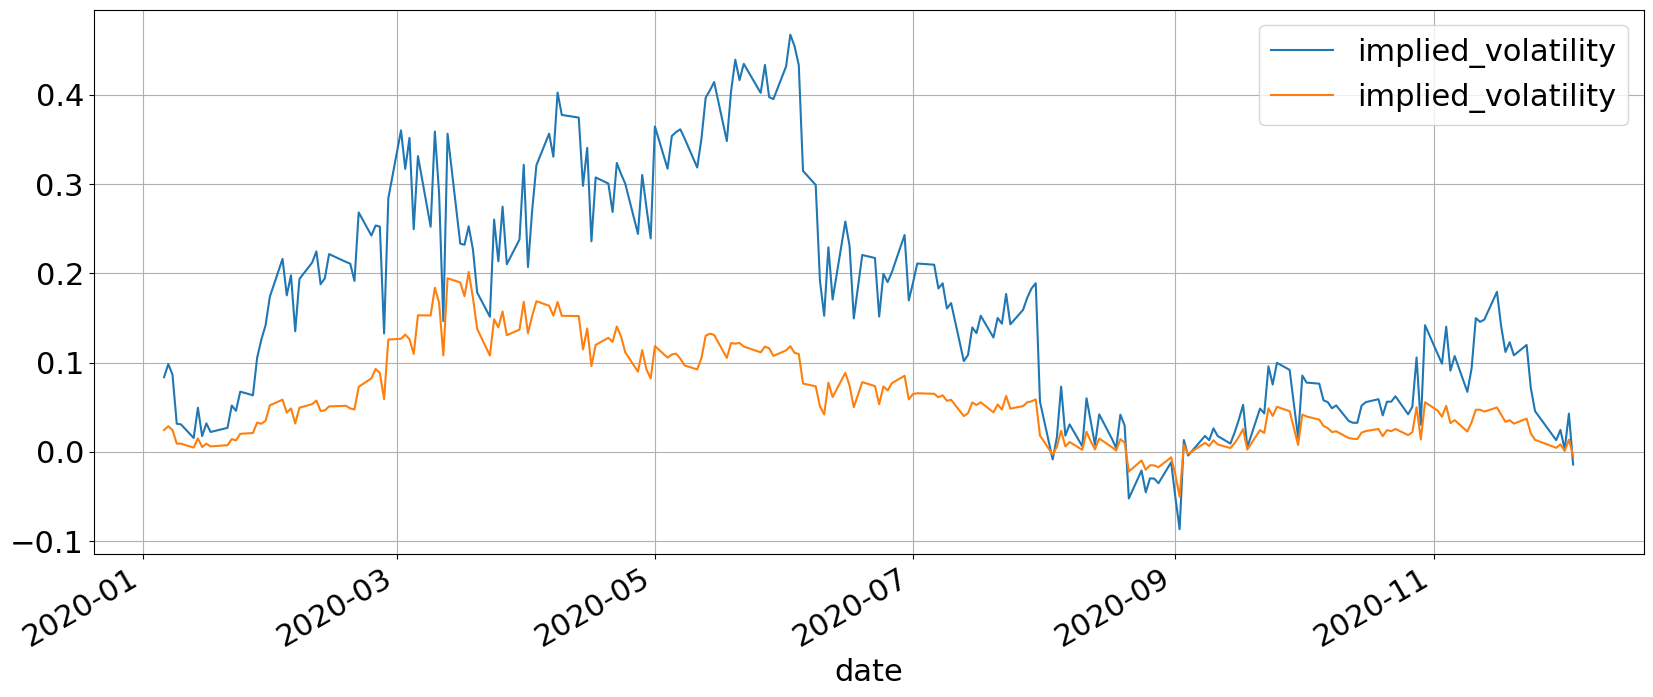

In [134]:
skew_2 = (df_selected_90P.set_index("date")[["implied_volatility"]]-df_selected_110C.set_index("date")[["implied_volatility"]])/df_selected_100C.set_index("date")[["implied_volatility"]]

ax = skew_2.plot(grid=True, figsize=(20,8))
skew_1.plot(grid=True, figsize=(20,8),ax=ax)

<Axes: xlabel='date'>

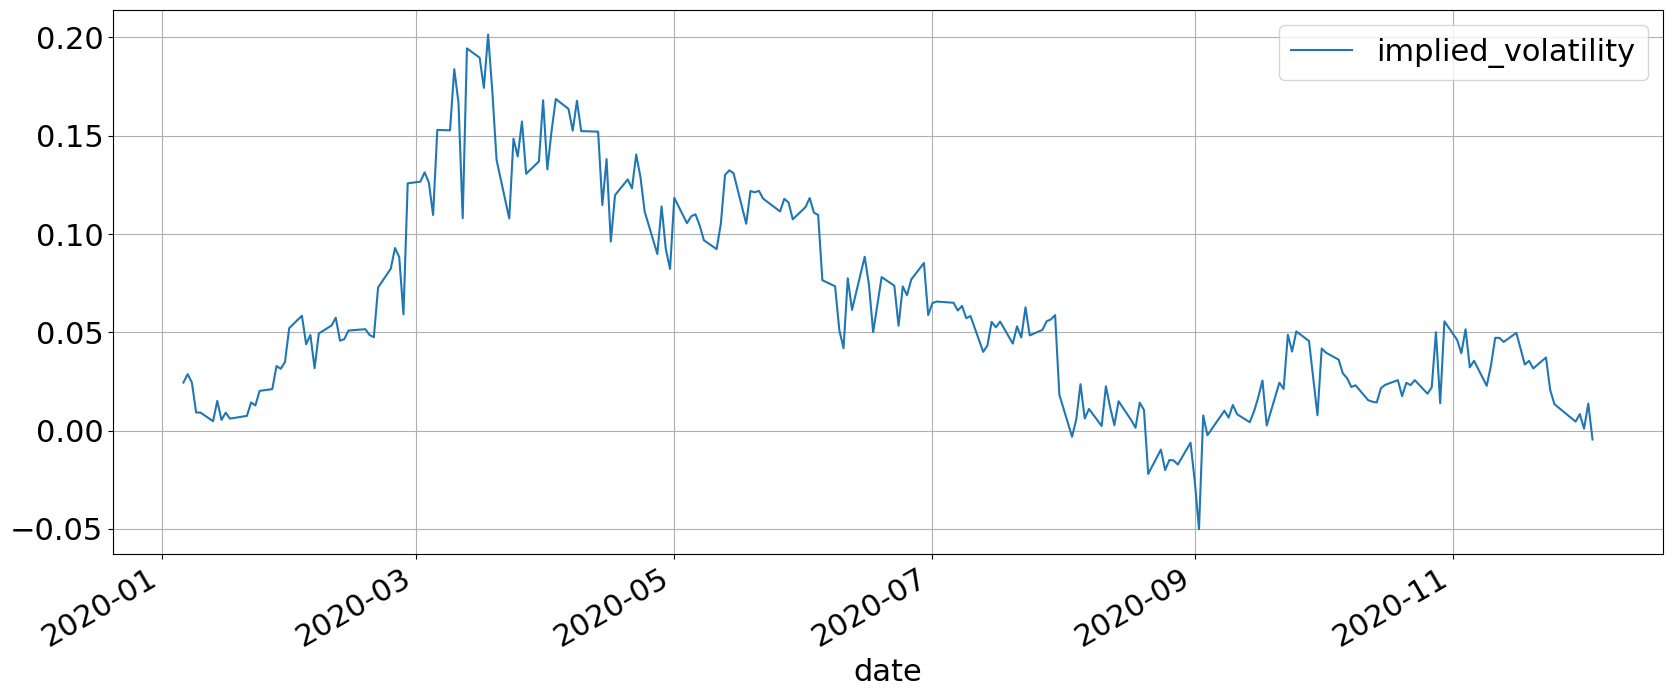

In [131]:
skew_1 = df_selected_90P.set_index("date")[["implied_volatility"]]-df_selected_110C.set_index("date")[["implied_volatility"]]

# df_selected_100C.set_index("date")[["implied_volatility"]]

skew_1.plot(grid=True, figsize=(20,8))

<Axes: xlabel='date'>

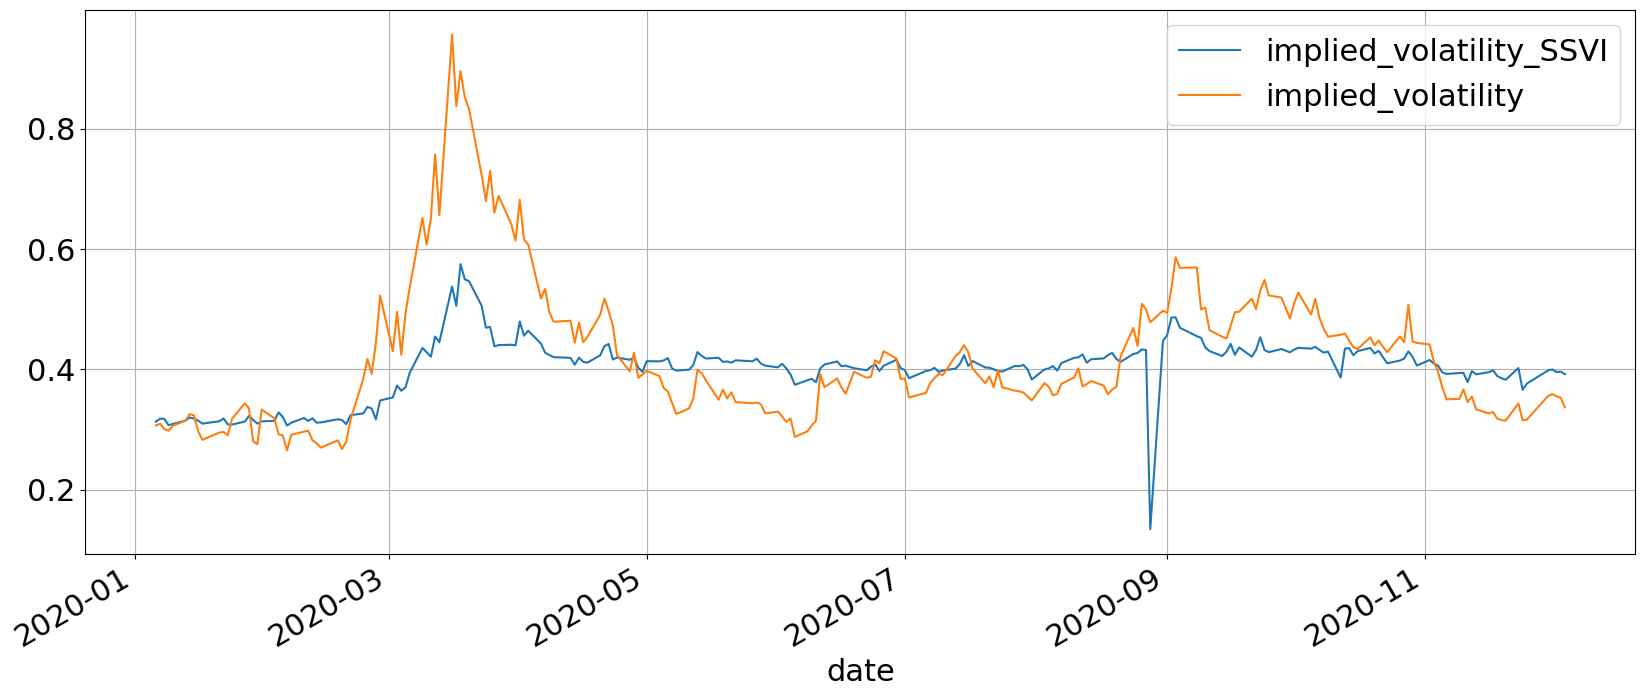

In [129]:
df_selected_opts.set_index("date")[["implied_volatility_SSVI","implied_volatility"]].plot(grid=True, figsize=(20,8))

In [ ]:


df_selected_opts.set_index("date")[["implied_volatility_SSVI","implied_volatility"]].plot(grid=True, figsize=(20,8))